In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pickle
from utils import * 

In [2]:
features = ["DealersInCompetition", "FirmAccount", "IssuedAmount", "Oas", "BidAskSpread", "Side", "BookName", "KeyRatioPrice"]

# Read the CSV file into a pandas DataFrame
file_path = "data/data.csv"
df = pd.read_csv(file_path)


count    6174.000000
mean        0.040094
std         0.099944
min        -0.899000
25%         0.011000
50%         0.021000
75%         0.043000
max         3.299000
Name: Spread, dtype: float64
4.1980000000000075


<Axes: xlabel='Spread', ylabel='Count'>

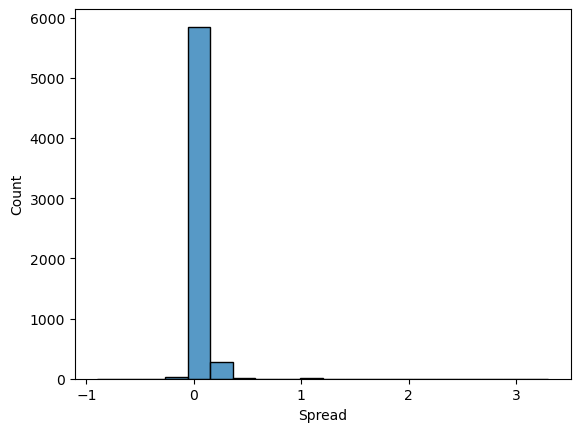

In [3]:
df["Direction"] = df["Side"].apply(lambda x: -1 if x == "BUY" else 1)
df["Direction"] = df["Direction"].astype(float)

# Create actions as spread  independent of the side (using "Direction"). Should I use ALLQ average as mid? 
df["Spread"] = df["Direction"] * (df["Price"]-df["Mid"])

#Look at distribution of actions
print(df.Spread.describe())
print(np.max(df["Spread"])-np.min(df["Spread"]))
sns.histplot(df["Spread"], bins=20)


count    5798.000000
mean        0.028816
std         0.029000
min        -0.029000
25%         0.011000
50%         0.021000
75%         0.040000
max         0.150000
Name: Spread, dtype: float64


<Axes: xlabel='Spread', ylabel='Count'>

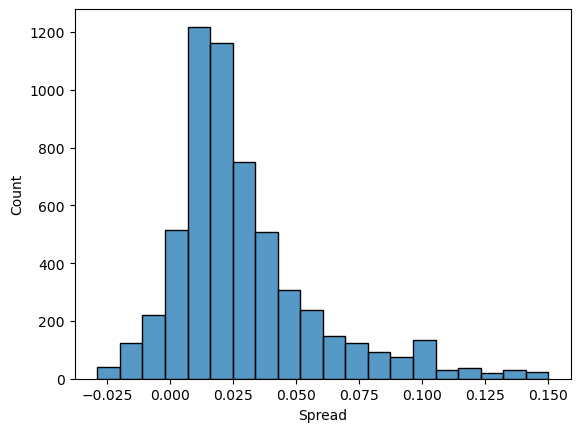

In [4]:
#We want a reasonable number of actions so outliers are removed
lower_spread_limit = -0.03
upper_spread_limit = 0.15


df = df[(df.Spread > lower_spread_limit) & (df.Spread < upper_spread_limit)]
print(df.Spread.describe())
sns.histplot(df["Spread"], bins=20)

### Define reward for each trade 

In [5]:
resultWon = (df.Result == "Won") | (df.Result == 1)
resultLost = (df.Result == "Lost") | (df.Result == 0)

sideBuy = (df.Side == "BUY") | (df.Side == 1)
sideSell = (df.Side == "SELL") | (df.Side == 0)
        
df.loc[sideBuy & resultWon, "Reward"] = (df.Mid-df.Price)   #Potentially add *df.Amount
df.loc[sideSell & resultWon, "Reward"] = (df.Price-df.Mid)  #Potentially add *df.Amount
df.loc[resultLost, "Reward"] = 0


### Find numeric values to discretize

In [6]:
#Features of interest
columns_of_interest = features + ["Reward", "Spread"]
df = df[columns_of_interest]

df = df.dropna()

#Extract numerical values
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

columns_to_exclude = ['Spread', 'Reward']

numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]

#Group low frequency firms into "Other"
df['FirmAccount'].value_counts(normalize=True)
df['FirmAccount'] = df['FirmAccount'].mask(df['FirmAccount'].map(df['FirmAccount'].value_counts(normalize=True)) < 0.03, 'Other')


df.describe()


,DealersInCompetition,IssuedAmount,Oas,BidAskSpread,KeyRatioPrice,Reward,Spread
count,5775.000000,5.775000e+03,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000
mean,2.975411,2.146548e+10,-0.275684,0.389143,97.182016,0.005354,0.028822
std,1.327972,1.094876e+10,0.305159,0.107031,3.216335,0.014250,0.029018
min,1.000000,9.617568e+07,-1.979236,0.200000,81.000000,-0.029000,-0.029000
25%,2.000000,1.397364e+10,-0.414042,0.400000,95.008000,0.000000,0.011000
50%,3.000000,1.989992e+10,-0.233377,0.400000,98.032000,0.000000,0.021000
75%,4.000000,2.775774e+10,-0.113856,0.400000,100.117500,0.000000,0.040000
max,9.000000,5.598030e+10,8.680538,1.000000,101.580000,0.150000,0.150000


### Map given spread to integer index

In [7]:
#We have to map the action to some integer we can use as index in Q-table 
# Example usage
value_to_map = 0.045
mapped_index = map_spread_to_int(value_to_map, lower_spread_limit, upper_spread_limit)
print(f"The mapped index for {value_to_map} is {mapped_index}")

# Example usage
mapped_index_to_reverse = 75
reversed_value = map_int_to_spread(mapped_index_to_reverse, lower_spread_limit, upper_spread_limit)
print(f"The reversed value for index {mapped_index_to_reverse} is {reversed_value}")



The mapped index for 0.045 is 75
The reversed value for index 75 is 0.045


### Discretization

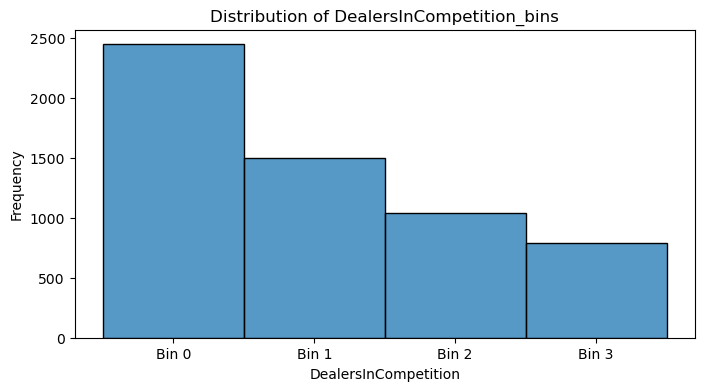

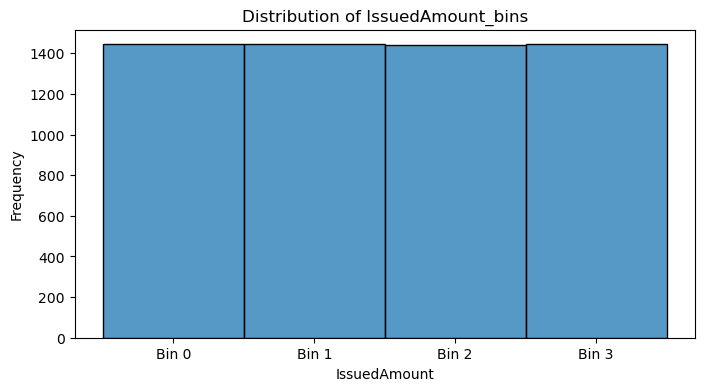

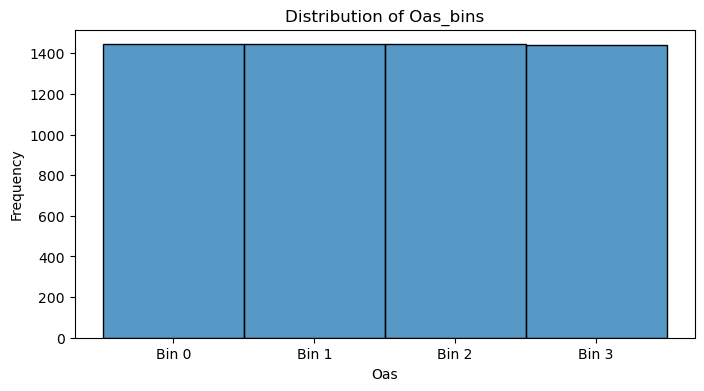

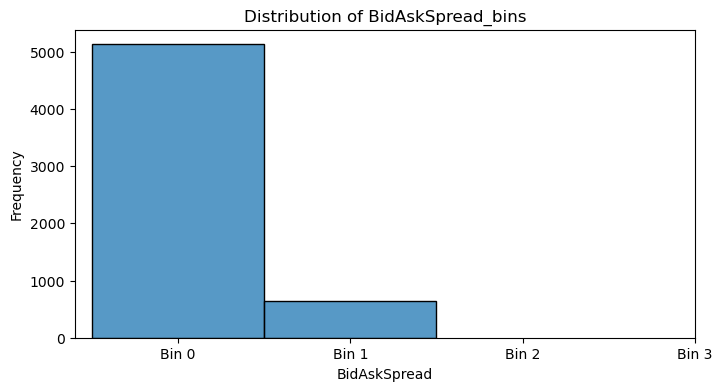

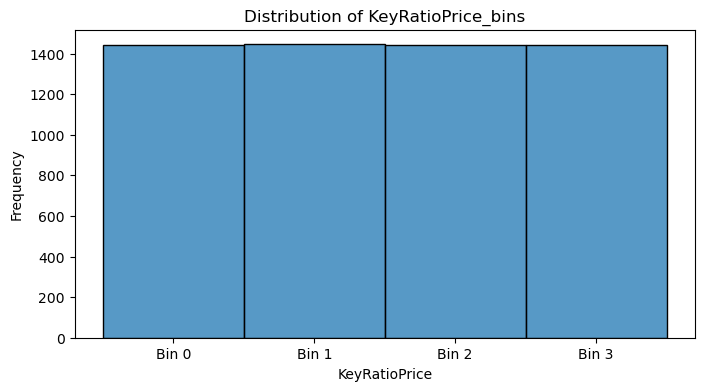

Index(['DealersInCompetition', 'FirmAccount', 'IssuedAmount', 'Oas',
       'BidAskSpread', 'Side', 'BookName', 'KeyRatioPrice', 'Reward', 'Spread',
       'DealersInCompetition_bins', 'IssuedAmount_bins', 'Oas_bins',
       'BidAskSpread_bins', 'KeyRatioPrice_bins', 'Firm_bins', 'Side_bins',
       'BookName_bins'],
      dtype='object')

In [8]:
# Discretization parameters
num_bins = 4
discretize_method = "number"

# Iterate over all columns (features) in the dataframe
for col in numeric_columns:
    if col != "Spread" or col != "Reward": 
        if discretize_method == "width":
            #Equal width
            data_min = np.min(df[col])
            data_max = np.max(df[col])
            bin_edges = np.linspace(data_min, data_max, num_bins + 1)
            df[f"{col}_bins"] = np.digitize(df[col], bin_edges[1:-1])
        else:
            #Equal number 
            df[f"{col}_bins"] = pd.qcut(df[col], num_bins, labels=False, duplicates="drop")
    plt.figure(figsize=(8, 4))
    sns.histplot(df[f"{col}_bins"], bins=num_bins, discrete=True)
    plt.title(f"Distribution of {col}_bins")
    plt.xlabel(col)
    bin_labels = [f"Bin {i}" for i in range(num_bins)]
    plt.xticks(range(num_bins), bin_labels) 
    plt.ylabel("Frequency")
    plt.show()

# Create a mapping from firm to index
firm_to_index = {firm: idx for idx, firm in enumerate(df['FirmAccount'].unique())}
side_to_index = {side: idx for idx, side in enumerate(df['Side'].unique())}
bookname_to_index = {bookname: idx for idx, bookname in enumerate(df['BookName'].unique())}

df['Firm_bins'] = df['FirmAccount'].map(firm_to_index)
df['Side_bins'] = df['Side'].map(side_to_index)
df['BookName_bins'] = df['BookName'].map(bookname_to_index)

# Initialize Q-table (rows for each firm, columns for actions)
num_firms = len(firm_to_index)
num_side = len(side_to_index)
num_bookname = len(side_to_index)


df.columns

### Make final df with (s,a,r,ns)

In [9]:
bin_features = [f"{item}_bins" for item in numeric_columns]
bin_features += ["Firm_bins", "Side_bins", "BookName_bins"]
bin_features

['DealersInCompetition_bins',
 'IssuedAmount_bins',
 'Oas_bins',
 'BidAskSpread_bins',
 'KeyRatioPrice_bins',
 'Firm_bins',
 'Side_bins',
 'BookName_bins']

In [10]:

# Create a new column 'State' containing lists of values (statevector) from the relevant features
df['State'] = df.apply(lambda row: [row[feat] for feat in bin_features], axis=1)

# Create a new DataFrame with the first column as the lists of combined features
final_df = pd.DataFrame({'State': df['State']})

num_values = [num_bins] * len(numeric_columns) + [num_firms,num_side,num_bookname]

final_df["State_index"] = final_df['State'].map(lambda x: state_to_index(x, num_values)) 
final_df["Action"] = df["Spread"].map(lambda x: map_spread_to_int(x, lower_spread_limit, upper_spread_limit))
final_df["Reward"] = df["Reward"]
final_df["Next_State"] = final_df['State_index'].shift(-1).fillna(-1).astype(int)


# Print the new DataFrame
df_filtered = final_df.drop(columns=['State'])
df_filtered.to_csv('data/trajectory.csv')

In [11]:
print("number of different states in dataset: ", len(final_df['State_index'].value_counts()))
print("size of statespace: ", np.prod(num_values))
print("state coverage by trajectory: ", len(final_df['State_index'].value_counts()) / np.prod(num_values))

number of different states in dataset:  1408
size of statespace:  32768
state coverage by trajectory:  0.04296875


In [12]:
#save variables needed to create Q-table 
vars = [lower_spread_limit, upper_spread_limit, num_values]
with open('data/shared_variables.pkl', 'wb') as my_file_obj:
    pickle.dump(vars, my_file_obj)